GAT (Graph Attention Network) 原理演示

1. 创建示例图:
   - 节点数量: 5
   - 特征维度: 4
   - 边数量: 5

2. 节点特征矩阵 h (每个节点4维特征):
   节点0: [1. 0. 0. 0.]
   节点1: [0. 1. 0. 0.]
   节点2: [0. 1. 0. 0.]
   节点3: [0. 0. 1. 0.]
   节点4: [0. 0. 0. 1.]

3. 邻接矩阵 adj (1表示有边，0表示无边):
[[0 1 1 1 1]
 [1 0 1 0 0]
 [1 1 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]

4. GAT层结构:
   - 输入维度: 4
   - 输出维度: 8
   - 可学习参数:
     * W (权重矩阵): torch.Size([4, 8])
     * a (注意力向量): torch.Size([16, 1])

5. GAT前向传播过程详解:

步骤1: 线性变换 Wh = h @ W
----------------------------------------------------------------------
   输入 h shape: torch.Size([5, 4])
   权重矩阵 W shape: torch.Size([4, 8])
   输出 Wh shape: torch.Size([5, 8])

   每个节点的变换后特征(前2维):
   节点0: Wh[0] = [0.19758055 0.1430512 ] ...
   节点1: Wh[1] = [-0.6577239  0.1193973] ...
   节点2: Wh[2] = [-0.6577239  0.1193973] ...
   节点3: Wh[3] = [-0.2890934   0.48942158] ...
   节点4: Wh[4] = [0.4221107  0.22682743] ...

   说明: 将每个节点的4维特征通过可学习的权重矩阵W映射到8维空间


步骤2: 计算注意力分数
-----------------------------------------------------

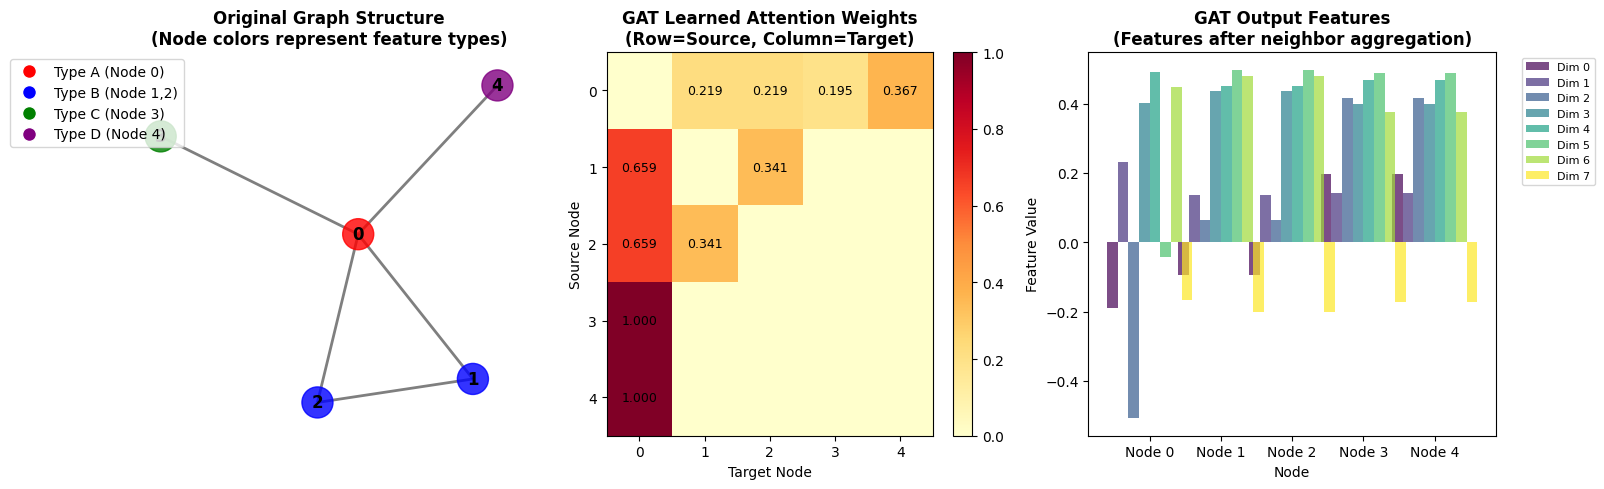


GAT的核心优势:
1. 自适应注意力: 不是简单地平均邻居信息，而是学习重要的邻居
2. 可解释性强: 注意力权重可以直接解释为节点间的重要性
3. 并行计算: 可以同时计算所有节点对的注意力
4. 特征敏感: 根据节点特征动态调整注意力权重

在本示例中:
- 节点0通过注意力机制，自适应地从邻居节点1,2,3,4中聚合信息
- 注意力权重表明了节点0更依赖哪些邻居的信息
- 特征相似的节点(如节点1和2)可能会得到相似的注意力

对比: GAT vs 平均池化

节点0的特征对比:
GAT输出:  [-0.1837089  -0.41710955 -0.20886563 -0.14201201  0.2262849   0.19392063
 -0.01203539  0.50296634]
平均池化: [-0.19062263 -0.27831453 -0.23828848 -0.20497343  0.12124856  0.15886141
 -0.10311324  0.49482656]

节点0的注意力分布:
GAT:      [0.         0.30701944 0.30701944 0.23946963 0.14649147]
平均池化: [0.   0.25 0.25 0.25 0.25]

结论:
- GAT: 根据节点特征学习差异化的注意力权重
- 平均池化: 对所有邻居使用相同的权重 (1/度)
- GAT能够更好地捕捉节点间的关系强度差异

演示完成！生成的图片 'gat_visualization.png' 展示了:
1. 原始图结构
2. GAT学习到的注意力权重
3. GAT输出特征


In [4]:
"""
GAT (Graph Attention Network) 直观示例代码
展示图注意力网络如何学习节点间的关系权重

本示例将演示：
1. GAT如何计算注意力权重
2. 注意力机制如何自适应地聚合邻居信息
3. 可视化注意力权重矩阵
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch


class SimpleGATLayer(nn.Module):
    """
    简化的GAT层实现，用于演示原理
    """
    def __init__(self, in_features, out_features, num_heads=1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_heads = num_heads
        
        # 线性变换矩阵 W: (in_features, out_features)
        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
        
        # 注意力向量 a: (2 * out_features, 1)
        self.a = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        
        # 初始化参数
        nn.init.xavier_uniform_(self.W.data)
        nn.init.xavier_uniform_(self.a.data)
    
    def forward(self, h, adj):
        """
        参数:
            h: 节点特征矩阵 (num_nodes, in_features)
            adj: 邻接矩阵 (num_nodes, num_nodes)
        """
        num_nodes = h.size(0)
        
        # 1. 线性变换: Wh = h @ W
        # 将每个节点的特征映射到新的空间
        Wh = torch.mm(h, self.W)  # (num_nodes, out_features)
        
        # 2. 计算注意力分数
        # 对每对节点(i,j)，计算它们之间的注意力系数
        
        # 使用广播机制计算所有节点对的注意力
        # a: (2*out_features, 1) -> 拆分为两部分
        a1 = self.a[:self.out_features, :]  # (out_features, 1)
        a2 = self.a[self.out_features:, :]  # (out_features, 1)
        
        # Wh @ a1: (num_nodes, 1) - 每个节点的第一部分注意力分数
        # Wh @ a2: (num_nodes, 1) - 每个节点的第二部分注意力分数
        # 使用广播机制得到注意力矩阵
        attention_input = Wh @ a1 + (Wh @ a2).T  # (num_nodes, num_nodes)
        
        # 3. 应用邻接矩阵遮罩
        # 如果两个节点之间没有边，将注意力设为很小的负数
        mask = (adj == 0).float()
        attention = attention_input.masked_fill(mask == 1, -9e15)
        
        # 4. Softmax归一化得到注意力权重
        attention = F.softmax(attention, dim=1)  # (num_nodes, num_nodes)
        
        # 5. 使用注意力权重聚合邻居信息
        h_prime = torch.matmul(attention, Wh)  # (num_nodes, out_features)
        
        return h_prime, attention


def create_example_graph():
    """
    创建一个简单的示例图
    节点0作为中心节点，连接到其他节点
    """
    num_nodes = 5
    num_features = 4
    
    # 创建邻接矩阵
    adj = torch.zeros(num_nodes, num_nodes)
    # 节点0连接到其他所有节点
    adj[0, 1] = adj[1, 0] = 1
    adj[0, 2] = adj[2, 0] = 1
    adj[0, 3] = adj[3, 0] = 1
    adj[0, 4] = adj[4, 0] = 1
    # 节点1和2之间也有连接
    adj[1, 2] = adj[2, 1] = 1
    
    # 创建节点特征
    # 我们给不同的节点设置不同的特征，以便观察注意力
    h = torch.tensor([
        [1.0, 0.0, 0.0, 0.0],  # 节点0: 特征类型A
        [0.0, 1.0, 0.0, 0.0],  # 节点1: 特征类型B
        [0.0, 1.0, 0.0, 0.0],  # 节点2: 特征类型B (与节点1相似)
        [0.0, 0.0, 1.0, 0.0],  # 节点3: 特征类型C
        [0.0, 0.0, 0.0, 1.0],  # 节点4: 特征类型D
    ], dtype=torch.float32)
    
    return h, adj


def visualize_graph_and_attention(h, adj, attention_weights, output_features):
    """
    可视化图结构和注意力权重
    """
    fig = plt.figure(figsize=(16, 5))
    
    # 子图1: 原始图结构
    ax1 = plt.subplot(1, 3, 1)
    G = nx.from_numpy_array(adj.numpy())
    pos = nx.spring_layout(G, seed=42)
    
    # 绘制节点
    node_colors = ['red', 'blue', 'blue', 'green', 'purple']
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=500, alpha=0.8, ax=ax1)
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, ax=ax1)
    
    # 绘制标签
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax1)
    
    ax1.set_title('Original Graph Structure\n(Node colors represent feature types)', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # 添加图例说明
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Type A (Node 0)',
                  markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Type B (Node 1,2)',
                  markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Type C (Node 3)',
                  markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Type D (Node 4)',
                  markerfacecolor='purple', markersize=10),
    ]
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.3, 1))
    
    # 子图2: 注意力权重热图
    ax2 = plt.subplot(1, 3, 2)
    im = ax2.imshow(attention_weights.detach().numpy(), cmap='YlOrRd', aspect='auto')
    ax2.set_xticks(range(5))
    ax2.set_yticks(range(5))
    ax2.set_xlabel('Target Node', fontsize=10)
    ax2.set_ylabel('Source Node', fontsize=10)
    ax2.set_title('GAT Learned Attention Weights\n(Row=Source, Column=Target)', 
                  fontsize=12, fontweight='bold')
    
    # 添加数值标注
    for i in range(5):
        for j in range(5):
            if attention_weights[i, j] > 0.01:  # 只标注非零值
                text = ax2.text(j, i, f'{attention_weights[i, j]:.3f}',
                              ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax2)
    
    # 子图3: 输出特征对比
    ax3 = plt.subplot(1, 3, 3)
    features = output_features.detach().numpy()
    
    x = np.arange(5)
    width = 0.15
    
    # 绘制每个输出维度
    colors = plt.cm.viridis(np.linspace(0, 1, 8))
    for dim in range(8):
        offset = (dim - 3.5) * width
        ax3.bar(x + offset, features[:, dim], width, 
               label=f'Dim {dim}', color=colors[dim], alpha=0.7)
    
    ax3.set_xlabel('Node', fontsize=10)
    ax3.set_ylabel('Feature Value', fontsize=10)
    ax3.set_title('GAT Output Features\n(Features after neighbor aggregation)', 
                  fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'Node {i}' for i in range(5)])
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('gat_visualization.png', dpi=150, bbox_inches='tight')
    print("Visualization saved to gat_visualization.png")
    plt.show()


def demonstrate_gat_intuition():
    """
    演示GAT的核心思想
    """
    print("=" * 70)
    print("GAT (Graph Attention Network) 原理演示")
    print("=" * 70)
    print()
    
    # 创建示例图
    h, adj = create_example_graph()
    num_nodes = h.size(0)
    
    print("1. 创建示例图:")
    print(f"   - 节点数量: {num_nodes}")
    print(f"   - 特征维度: {h.size(1)}")
    print(f"   - 边数量: {adj.sum().int().item() // 2}")
    print()
    
    # 打印节点特征
    print("2. 节点特征矩阵 h (每个节点4维特征):")
    for i in range(num_nodes):
        print(f"   节点{i}: {h[i].numpy()}")
    print()
    
    # 打印邻接矩阵
    print("3. 邻接矩阵 adj (1表示有边，0表示无边):")
    print(adj.numpy().astype(int))
    print()
    
    # 创建GAT层
    gat_layer = SimpleGATLayer(in_features=4, out_features=8)
    
    print("4. GAT层结构:")
    print(f"   - 输入维度: 4")
    print(f"   - 输出维度: 8")
    print(f"   - 可学习参数:")
    print(f"     * W (权重矩阵): {gat_layer.W.shape}")
    print(f"     * a (注意力向量): {gat_layer.a.shape}")
    print()
    
    # 前向传播 - 逐步展示
    print("5. GAT前向传播过程详解:")
    print("=" * 70)
    
    # 步骤1: 线性变换
    print("\n步骤1: 线性变换 Wh = h @ W")
    print("-" * 70)
    Wh = torch.mm(h, gat_layer.W)
    print(f"   输入 h shape: {h.shape}")
    print(f"   权重矩阵 W shape: {gat_layer.W.shape}")
    print(f"   输出 Wh shape: {Wh.shape}")
    print(f"\n   每个节点的变换后特征(前2维):")
    for i in range(num_nodes):
        print(f"   节点{i}: Wh[{i}] = {Wh[i, :2].detach().numpy()} ...")
    print("\n   说明: 将每个节点的4维特征通过可学习的权重矩阵W映射到8维空间")
    
    # 步骤2: 计算注意力分数
    print("\n\n步骤2: 计算注意力分数")
    print("-" * 70)
    a1 = gat_layer.a[:gat_layer.out_features, :]
    a2 = gat_layer.a[gat_layer.out_features:, :]
    attention_scores = Wh @ a1 + (Wh @ a2).T
    print(f"   注意力向量a1 shape: {a1.shape}")
    print(f"   注意力向量a2 shape: {a2.shape}")
    print(f"   注意力分数矩阵 shape: {attention_scores.shape}")
    print(f"\n   节点0对其他节点的原始注意力分数:")
    for j in range(num_nodes):
        print(f"   节点0 -> 节点{j}: {attention_scores[0, j].item():.4f}")
    print("\n   公式: e_ij = LeakyReLU(a^T [Wh_i || Wh_j])")
    print("        其中 || 表示拼接操作，a是可学习的注意力向量")
    print("   说明: 计算每对节点(i,j)之间的相关性分数")
    
    # 步骤3: 应用邻接矩阵遮罩
    print("\n\n步骤3: 应用邻接矩阵遮罩")
    print("-" * 70)
    mask = (adj == 0).float()
    attention_masked = attention_scores.masked_fill(mask == 1, -9e15)
    print(f"   遮罩前的注意力分数(节点0): {attention_scores[0, :].detach().numpy()}")
    print(f"   遮罩后的注意力分数(节点0): {attention_masked[0, :].detach().numpy()}")
    print(f"   邻接矩阵(节点0): {adj[0, :].numpy().astype(int)}")
    print("\n   说明: 将没有边连接的节点对的注意力分数设为-9e15")
    print("        这样在后续的softmax中这些位置会接近于0")
    
    # 步骤4: Softmax归一化
    print("\n\n步骤4: Softmax归一化")
    print("-" * 70)
    attention = F.softmax(attention_masked, dim=1)
    print(f"   Softmax后的注意力权重(节点0): {attention[0, :].detach().numpy()}")
    print(f"   注意力权重总和: {attention[0, :].sum().item():.6f}")
    print("\n   公式: α_ij = exp(e_ij) / Σ_k exp(e_ik)")
    print("   说明: 将注意力分数转换为概率分布，每行的和为1")
    print("        有边连接的邻居节点得到非零权重，无边节点权重接近0")
    
    # 步骤5: 聚合邻居信息
    print("\n\n步骤5: 聚合邻居信息")
    print("-" * 70)
    h_prime = torch.matmul(attention, Wh)
    print(f"   注意力权重 shape: {attention.shape}")
    print(f"   变换后特征 Wh shape: {Wh.shape}")
    print(f"   聚合后特征 h' shape: {h_prime.shape}")
    print(f"\n   节点0的聚合过程:")
    print(f"   h'_0 = Σ_j α_0j * Wh_j")
    neighbors = [j for j in range(num_nodes) if adj[0, j] == 1]
    print(f"   节点0的邻居: {neighbors}")
    print(f"   对应的注意力权重: {[f'{attention[0, j].item():.4f}' for j in neighbors]}")
    print(f"\n   节点0聚合后的特征(前2维): {h_prime[0, :2].detach().numpy()} ...")
    print("\n   说明: 使用学习到的注意力权重加权聚合邻居节点特征")
    print("        每个节点的新特征融合了自身和所有邻居的信息")
    
    print("\n" + "=" * 70)
    print("前向传播完成！")
    print("=" * 70)
    print()
    
    # 展示注意力权重
    print("6. 学习到的注意力权重矩阵 (注意力机制的核心):")
    print("   行=源节点，列=目标节点")
    attention_np = attention.detach().numpy()
    for i in range(num_nodes):
        print(f"   节点{i}对其他节点的注意力:")
        for j in range(num_nodes):
            if attention_np[i, j] > 0.01:
                print(f"      -> 节点{j}: {attention_np[i, j]:.4f}", end='')
                if adj[i, j] == 1:
                    print(" (有连接)")
                else:
                    print()
        print()
    
    # 分析注意力模式
    print("7. 注意力模式分析:")
    print(f"   节点0的注意力分布:")
    neighbors_of_0 = [i for i in range(num_nodes) if adj[0, i] == 1]
    for j in neighbors_of_0:
        print(f"      对节点{j}的注意力: {attention_np[0, j]:.4f}")
    
    # 检查节点1和2（特征相似）
    if attention_np[0, 1] > 0 and attention_np[0, 2] > 0:
        print()
        print("   注意：节点1和2有相同的特征类型B")
        print(f"   节点0对节点1的注意力: {attention_np[0, 1]:.4f}")
        print(f"   节点0对节点2的注意力: {attention_np[0, 2]:.4f}")
        print("   GAT学会了关注特征相似的节点！")
    print()
    
    # 展示输出特征
    print("8. GAT输出特征 (节点聚合邻居信息后的特征):")
    print("   维度: 8")
    for i in range(num_nodes):
        print(f"   节点{i}: ", end='')
        print(f"[{', '.join([f'{h_prime[i, j]:.2f}' for j in range(8)])}]")
    print()
    
    # 可视化
    print("9. 生成可视化图表...")
    visualize_graph_and_attention(h, adj, attention, h_prime)
    print()
    
    # GAT的优势
    print("=" * 70)
    print("GAT的核心优势:")
    print("=" * 70)
    print("1. 自适应注意力: 不是简单地平均邻居信息，而是学习重要的邻居")
    print("2. 可解释性强: 注意力权重可以直接解释为节点间的重要性")
    print("3. 并行计算: 可以同时计算所有节点对的注意力")
    print("4. 特征敏感: 根据节点特征动态调整注意力权重")
    print()
    print("=" * 70)
    print("在本示例中:")
    print("=" * 70)
    print("- 节点0通过注意力机制，自适应地从邻居节点1,2,3,4中聚合信息")
    print("- 注意力权重表明了节点0更依赖哪些邻居的信息")
    print("- 特征相似的节点(如节点1和2)可能会得到相似的注意力")
    print("=" * 70)


def compare_with_mean_pooling():
    """
    对比GAT和简单的平均池化
    """
    print("\n" + "=" * 70)
    print("对比: GAT vs 平均池化")
    print("=" * 70)
    
    h, adj = create_example_graph()
    gat_layer = SimpleGATLayer(in_features=4, out_features=8)
    
    # GAT
    h_gat, attention = gat_layer(h, adj)
    
    # 平均池化
    deg = adj.sum(dim=1, keepdim=True)
    deg[deg == 0] = 1  # 避免除以0
    attention_mean = adj / deg
    W = gat_layer.W
    Wh = torch.mm(h, W)
    h_mean = torch.mm(attention_mean, Wh)
    
    print("\n节点0的特征对比:")
    print(f"GAT输出:  {h_gat[0].detach().numpy()}")
    print(f"平均池化: {h_mean[0].detach().numpy()}")
    
    print(f"\n节点0的注意力分布:")
    print(f"GAT:      {attention[0].detach().numpy()}")
    print(f"平均池化: {attention_mean[0].detach().numpy()}")
    
    print("\n结论:")
    print("- GAT: 根据节点特征学习差异化的注意力权重")
    print("- 平均池化: 对所有邻居使用相同的权重 (1/度)")
    print("- GAT能够更好地捕捉节点间的关系强度差异")


if __name__ == "__main__":
    # 运行主演示
    demonstrate_gat_intuition()
    
    # 对比实验
    compare_with_mean_pooling()
    
    print("\n演示完成！生成的图片 'gat_visualization.png' 展示了:")
    print("1. 原始图结构")
    print("2. GAT学习到的注意力权重")
    print("3. GAT输出特征")

In [1]:
print("hello")

hello
